In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
#import gresearch_crypto
import time
import datetime
import catboost

import pickle
import gc

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
import xgboost as xgb




#from catboost import CatBoostClassifier ,Pool
from google.colab import autoviz
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error

use_supple_for_train = True

not_use_overlap_to_train = False

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 350)

In [ ]:
class CFG :
  seed = 123
  n_splits = 10
 # nboost = 20000
  #nperiod = 500
  N_Plot = 40

  lgb_params =  {
            'n_jobs': -1,
            'max_depth' : -1,
            'objective': 'regression',
            'metric': ['mape','mae','rmse'],
            'boosting_type': 'gbdt',
            'verbose': -1,
            'max_bin':1000,
            'min_data_in_leaf':6,
            'num_leaves': 260,
            'learning_rate': 0.03,
            'subsample': 0.9,
            'subsample_freq': 1,
            'feature_fraction': 1,
            'lambda_l1': 2,
            'lambda_l2': 2,
            'num_boost_round': 10000,

       }

  cat_params = {
        'iterations': 1000,
        'depth': 6,
        'learning_rate': 0.1,
        'loss_function': 'RMSE',
        # Add other CatBoost parameters as needed
    }

  xgb_params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',  # Use a regression objective
    'eval_metric': 'mape',  # Set the evaluation metric to MAPE
    # Add other custom parameters as needed
  }

  TARGET_COL = 'Energy'

  remove_column = ['ESMode3','ESMode4','ESMode5','folds','Bins','BS','BS_id',
                   'Mode','Energy','month', 'year','Time','Unnamed: 0'
                   ]




data_path = '/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/File/'
folder_path_model = '/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/'
submit_path = '/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Submit/'
base_path = '/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/'

# Data load

In [ ]:
titanic_path = '/content/drive/MyDrive/titanic/'
train_path = f"{titanic_path}train.csv"
test_path =  f"{titanic_path}test.csv"

In [ ]:
bsb_path = f"{base_path}Base Station basic information.csv"
cel_path = f"{base_path}Cell-level data.csv"
ecd_path = f"{base_path}Energy consumption data.csv"
pcw_path = f"{base_path}power_consumption_prediction.csv"
sb_path =  f"{base_path}SampleSubmission.csv"

In [ ]:
bsb = pd.read_csv(bsb_path)
cel = pd.read_csv(cel_path)
ecd = pd.read_csv(ecd_path)
pcw = pd.read_csv(pcw_path)
sb = pd.read_csv(sb_path)

In [ ]:
pcw

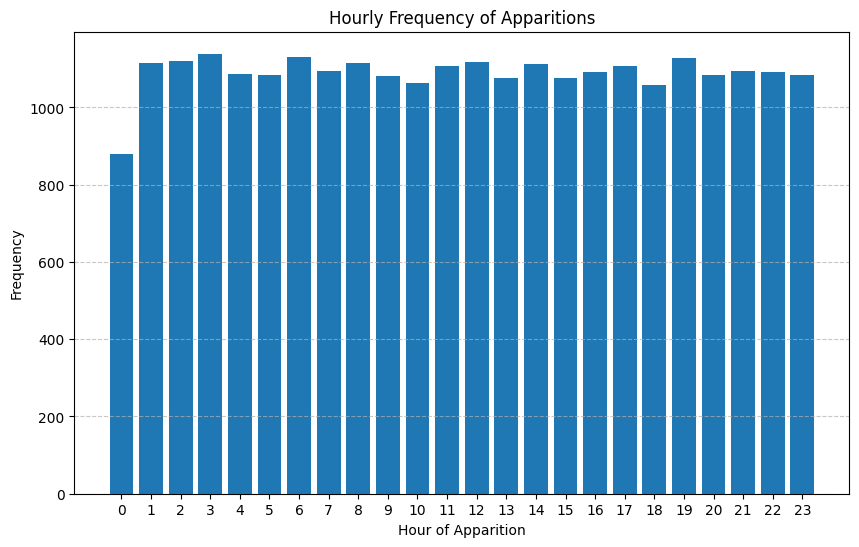

In [ ]:
pcw['Time'] = pd.to_datetime(pcw['Time'])

# Extract the hour from the 'Time' column and create a new column 'Hour'
pcw['Hour'] = pcw['Time'].dt.hour

# Group by 'Hour' and calculate the frequency of apparitions
hourly_frequency = pcw.groupby('Hour').size()

# Plot the hour of apparition frequency
plt.figure(figsize=(10, 6))
plt.bar(hourly_frequency.index, hourly_frequency.values)
plt.xlabel('Hour of Apparition')
plt.ylabel('Frequency')
plt.title('Hourly Frequency of Apparitions')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
bsb

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.00,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.00,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...
1214,B_745,Cell2,Type1,Mode2,426.98,2,2,6.877429
1215,B_105,Cell3,Type1,Mode2,426.98,2,2,6.877429
1216,B_745,Cell3,Type1,Mode2,426.98,2,2,6.877429


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(bsb, *['Frequency'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(bsb, *['Bandwidth'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(bsb, *['Antennas'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(bsb, *['TXpower'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(bsb, *['Frequency'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(bsb, *['Bandwidth'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(bsb, *['Antennas'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(bsb, *['TXpower'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(bsb, *['CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(bsb, *['Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(bsb, *[[['Frequency', 'Bandwidth'], ['Bandwidth', 'Antennas'], ['Antennas', 'TXpower']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(bsb, *['CellName', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(bsb, *['Frequency', 'CellName'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(bsb, *['Frequency', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(bsb, *['Bandwidth', 'CellName'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(bsb, *['Bandwidth', 'Mode'], **{'inner': 'box'})
chart

In [ ]:
cel

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
125572,1/2/2023 21:00,B_745,Cell3,0.081865,0.0,0.0,0.0,0,0.0,0.0
125573,1/2/2023 22:00,B_745,Cell3,0.097615,0.0,0.0,0.0,0,0.0,0.0
125574,1/2/2023 23:00,B_745,Cell3,0.066212,0.0,0.0,0.0,0,0.0,0.0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cel, *['load'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cel, *['ESMode1'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cel, *['ESMode2'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cel, *['ESMode3'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cel, *['load'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cel, *['ESMode1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cel, *['ESMode2'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cel, *['ESMode3'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(cel, *['CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(cel, *[[['load', 'ESMode1'], ['ESMode1', 'ESMode2'], ['ESMode2', 'ESMode3'], ['ESMode3', 'ESMode5']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(cel, *['load', 'CellName'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(cel, *['ESMode1', 'CellName'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(cel, *['ESMode2', 'CellName'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(cel, *['ESMode3', 'CellName'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cel, *['Time', 'load', 'CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cel, *['Time', 'ESMode1', 'CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cel, *['Time', 'ESMode2', 'CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cel, *['Time', 'ESMode3', 'CellName'], **{})
chart

In [ ]:
ecd

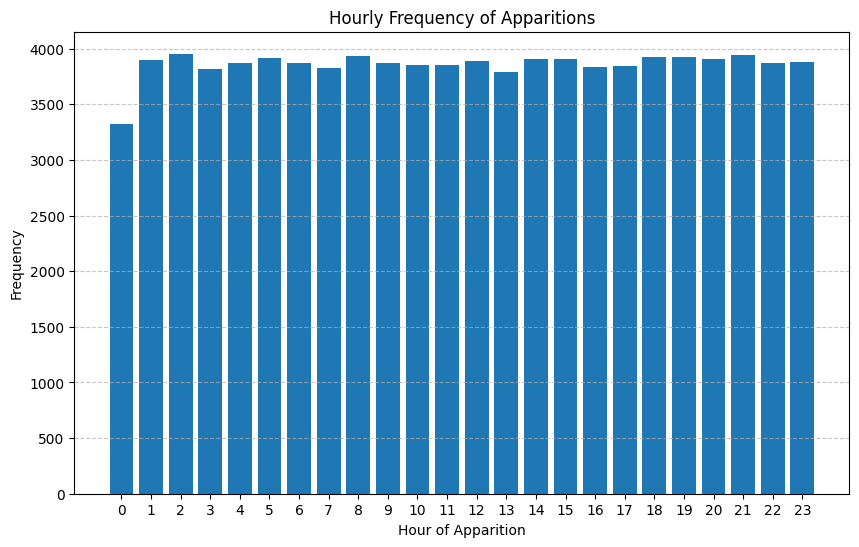

In [ ]:
ecd['Time'] = pd.to_datetime(ecd['Time'])

# Extract the hour from the 'Time' column and create a new column 'Hour'
ecd['Hour'] = ecd['Time'].dt.hour

# Group by 'Hour' and calculate the frequency of apparitions
hourly_frequency = ecd.groupby('Hour').size()

# Plot the hour of apparition frequency
plt.figure(figsize=(10, 6))
plt.bar(hourly_frequency.index, hourly_frequency.values)
plt.xlabel('Hour of Apparition')
plt.ylabel('Frequency')
plt.title('Hourly Frequency of Apparitions')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Group the data by 'BS' class and calculate the sum of 'w' for each class
class_weights = pcw.groupby('BS')['w'].sum().reset_index()

# Calculate the length of each group
class_lengths = pcw.groupby('BS').size().reset_index(name='length')

# Merge the class_weights and class_lengths DataFrames on the 'BS' column
class_weights = class_weights.merge(class_lengths, on='BS')

# Calculate the normalized weight by dividing 'w' by the length of each group
class_weights['normalized_weight'] = class_weights['w'] / class_weights['length']
# Drop the 'w' and 'length' columns
class_weights.drop(columns=['w', 'length'], inplace=True)

# Rename the 'normalized_weight' column to 'w'
class_weights.rename(columns={'normalized_weight': 'w'}, inplace=True)
# Print the result
class_weights
#selected_row = class_weights[class_weights['BS'] == 'B_1019']
#selected_row

,BS,w
0,B_0,1.0
1,B_1,1.0
2,B_10,1.0
...,...,...
1015,B_997,1.0
1016,B_998,1.0
1017,B_999,1.0


# EDA

In [ ]:
ecd['Time'] = pd.to_datetime(ecd['Time'])
cel['Time'] = pd.to_datetime(cel['Time'])
pcw['Time'] = pd.to_datetime(pcw['Time'])

merged = pd.merge(cel, ecd, on=['Time', 'BS'])
merged_df = pd.merge(merged, bsb, on=['CellName', 'BS'])
merged_df = pd.merge(merged_df, class_weights, on=['BS'])


merged_test = pd.merge(cel, pcw, on=['Time', 'BS'])

merged_df_test = pd.merge(merged_test, bsb, on=['CellName', 'BS'])

label_encoder = LabelEncoder()

merged_df["BS_id"] = merged_df["BS"]
merged_df_test["BS_id"] = merged_df_test["BS"]
columns_to_encode = ["BS_id", "CellName", "RUType"]

for column in columns_to_encode:
    merged_df[column] = label_encoder.fit_transform(merged_df[column])
    merged_df_test[column] = label_encoder.fit_transform(merged_df_test[column])

In [ ]:
csv_filename = 'df_transformed_train.csv'
csv_filename_test = 'df_transformed_test.csv'
merged_df_test.to_csv(os.path.join(data_path, csv_filename_test), index=True)
merged_df.to_csv(os.path.join(data_path, csv_filename), index=True)

In [ ]:
merged_df_test = pd.read_csv('/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/File/df_transformed_test.csv')
merged_df = pd.read_csv('/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/File/df_transformed_train.csv')

In [ ]:
merged_df

,Unnamed: 0,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,Energy,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,w,BS_id
0,0,2023-01-01 01:00:00,B_0,0,0.487936,0.0,0.0,0.0,0,0.0,0.000000,64.275037,0,Mode2,365.00,20,4,6.875934,1.0,0
1,1,2023-01-01 02:00:00,B_0,0,0.344468,0.0,0.0,0.0,0,0.0,0.000000,55.904335,0,Mode2,365.00,20,4,6.875934,1.0,0
2,2,2023-01-01 03:00:00,B_0,0,0.193766,0.0,0.0,0.0,0,0.0,0.000000,57.698057,0,Mode2,365.00,20,4,6.875934,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98033,98033,2023-01-02 21:00:00,B_1018,0,0.055538,0.0,0.0,0.0,0,0.0,0.846935,13.452915,7,Mode2,426.98,2,2,7.325859,1.0,10
98034,98034,2023-01-02 22:00:00,B_1018,0,0.058077,0.0,0.0,0.0,0,0.0,0.856434,13.602392,7,Mode2,426.98,2,2,7.325859,1.0,10
98035,98035,2023-01-02 23:00:00,B_1018,0,0.048173,0.0,0.0,0.0,0,0.0,0.879232,13.303438,7,Mode2,426.98,2,2,7.325859,1.0,10


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df, *['Unnamed: 0'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df, *['CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df, *['load'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df, *['ESMode1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df, *['Unnamed: 0'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df, *['CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df, *['load'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df, *['ESMode1'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(merged_df, *['Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(merged_df, *[[['Unnamed: 0', 'CellName'], ['CellName', 'load'], ['load', 'ESMode1'], ['ESMode1', 'ESMode2']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df, *['Unnamed: 0', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df, *['CellName', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df, *['load', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df, *['ESMode1', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df, *['Unnamed: 0', 'CellName', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df, *['Unnamed: 0', 'load', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df, *['Unnamed: 0', 'ESMode1', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df, *['Unnamed: 0', 'ESMode2', 'Mode'], **{})
chart

In [ ]:
merged_df_test

,Unnamed: 0,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,Energy,w,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,BS_id
0,0,2023-01-01 06:00:00,B_0,0,0.189872,0.0,0.0,0.0,0,0.0,0.000000,NaN,1,0,Mode2,365.000,20,4,6.875934,0
1,1,2023-01-01 11:00:00,B_0,0,0.522096,0.0,0.0,0.0,0,0.0,0.000000,NaN,1,0,Mode2,365.000,20,4,6.875934,0
2,2,2023-01-01 12:00:00,B_0,0,0.439968,0.0,0.0,0.0,0,0.0,0.000000,NaN,1,0,Mode2,365.000,20,4,6.875934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27488,27488,2023-01-02 21:00:00,B_1019,0,0.019940,0.0,0.0,0.0,0,0.0,0.627909,NaN,5,2,Mode1,697.002,10,2,7.086398,24
27489,27489,2023-01-02 22:00:00,B_1019,0,0.019940,0.0,0.0,0.0,0,0.0,0.627909,NaN,5,2,Mode1,697.002,10,2,7.086398,24
27490,27490,2023-01-02 23:00:00,B_1019,0,0.019940,0.0,0.0,0.0,0,0.0,0.627909,NaN,5,2,Mode1,697.002,10,2,7.086398,24


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df_test, *['Unnamed: 0'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df_test, *['CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df_test, *['load'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df_test, *['ESMode1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df_test, *['Unnamed: 0'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df_test, *['CellName'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df_test, *['load'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df_test, *['ESMode1'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(merged_df_test, *['Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(merged_df_test, *[[['Unnamed: 0', 'CellName'], ['CellName', 'load'], ['load', 'ESMode1'], ['ESMode1', 'ESMode2']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df_test, *['Unnamed: 0', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df_test, *['CellName', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df_test, *['load', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(merged_df_test, *['ESMode1', 'Mode'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df_test, *['Unnamed: 0', 'CellName', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df_test, *['Unnamed: 0', 'load', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df_test, *['Unnamed: 0', 'ESMode1', 'Mode'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df_test, *['Unnamed: 0', 'ESMode2', 'Mode'], **{})
chart

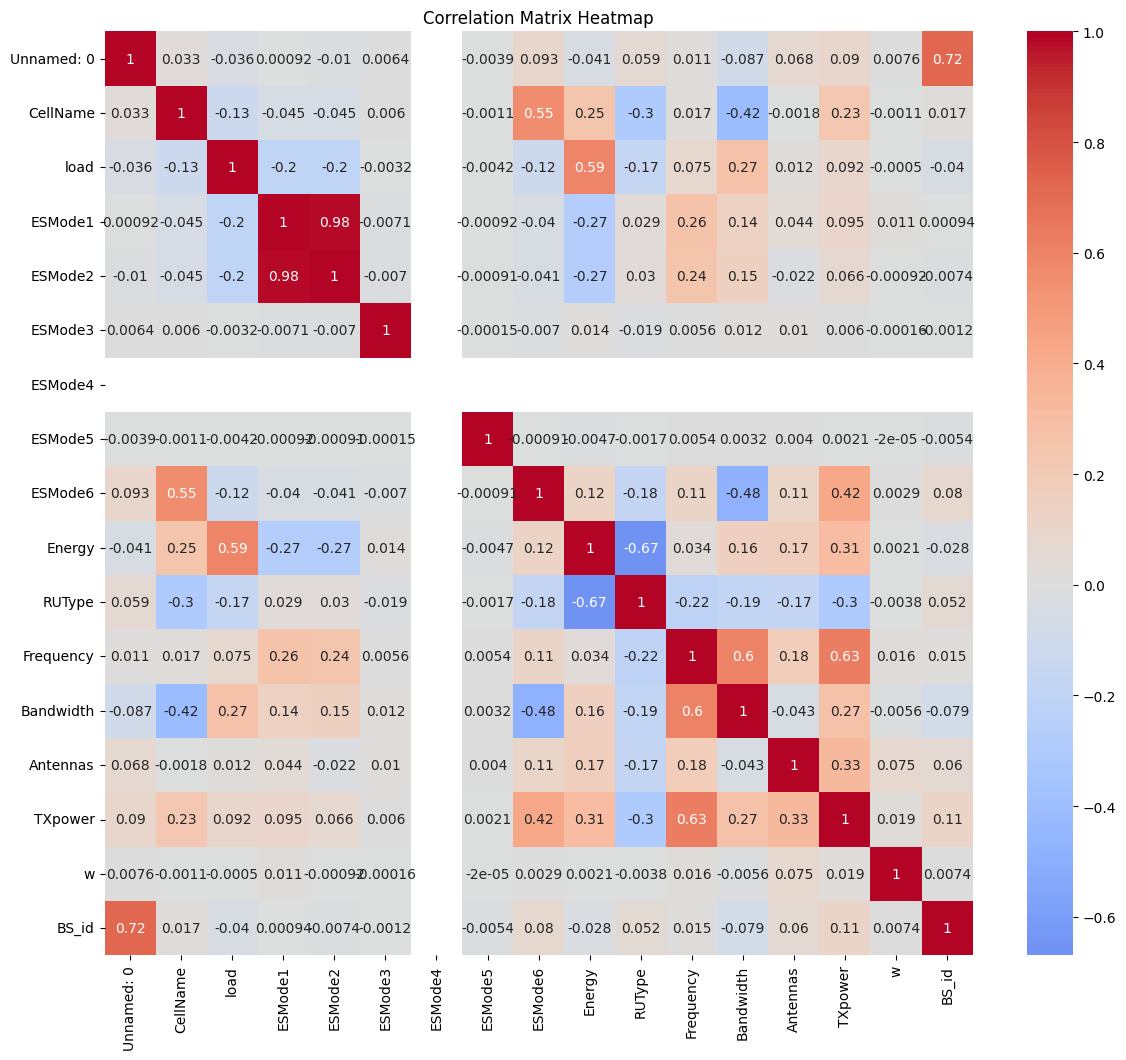

In [ ]:
#merged_df.drop(columns=CFG.remove_column, inplace=True)
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
merged_df

,Unnamed: 0,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,Energy,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,w,BS_id
0,0,2023-01-01 01:00:00,B_0,0,0.487936,0.0,0.0,0.0,0,0.0,0.000000,64.275037,0,Mode2,365.00,20,4,6.875934,1.0,0
1,1,2023-01-01 02:00:00,B_0,0,0.344468,0.0,0.0,0.0,0,0.0,0.000000,55.904335,0,Mode2,365.00,20,4,6.875934,1.0,0
2,2,2023-01-01 03:00:00,B_0,0,0.193766,0.0,0.0,0.0,0,0.0,0.000000,57.698057,0,Mode2,365.00,20,4,6.875934,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98033,98033,2023-01-02 21:00:00,B_1018,0,0.055538,0.0,0.0,0.0,0,0.0,0.846935,13.452915,7,Mode2,426.98,2,2,7.325859,1.0,10
98034,98034,2023-01-02 22:00:00,B_1018,0,0.058077,0.0,0.0,0.0,0,0.0,0.856434,13.602392,7,Mode2,426.98,2,2,7.325859,1.0,10
98035,98035,2023-01-02 23:00:00,B_1018,0,0.048173,0.0,0.0,0.0,0,0.0,0.879232,13.303438,7,Mode2,426.98,2,2,7.325859,1.0,10


In [ ]:
def get_top_correlated_features(data, target_column, threshold=0.25):
    correlations = {}
    for feature_column in data.columns:
        if feature_column != target_column:
            correlation = data[feature_column].corr(data[target_column])
            correlations[feature_column] = correlation

    # Filter the correlations to include only those above the specified threshold
    top_correlations = {k: v for k, v in correlations.items() if abs(v) > threshold}

    # Sort the filtered correlations by absolute value in descending order
    sorted_correlations = sorted(top_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    return sorted_correlations

In [ ]:
drop_columns = ['BS','Unnamed: 0','Time','Mode','w','BS_id','ESMode4','ESMode3','ESMode5']
data = merged_df.drop(columns=drop_columns, errors='ignore')
for col in data.columns:
  correlations = get_top_correlated_features(data, col)
  print(f'Target {col} = {correlations}')

In [ ]:
def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 10.2 * figscale)
  #print(series_colname)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]

      ys = series[value_colname]

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_df[:690], *['Time', 'Energy', 'BS'], **{})
chart


In [ ]:
num_unique_values = merged_df.nunique()

# Loop through each column and its corresponding unique value count
for column, count in num_unique_values.items():
    print(f"Column: {column}, Number of Unique Values: {count}")

Column: Unnamed: 0, Number of Unique Values: 98036
Column: Time, Number of Unique Values: 168
Column: BS, Number of Unique Values: 921
Column: CellName, Number of Unique Values: 4
Column: load, Number of Unique Values: 59245
Column: ESMode1, Number of Unique Values: 509
Column: ESMode2, Number of Unique Values: 1104
Column: ESMode3, Number of Unique Values: 169
Column: ESMode4, Number of Unique Values: 1
Column: ESMode5, Number of Unique Values: 4
Column: ESMode6, Number of Unique Values: 4155
Column: Energy, Number of Unique Values: 612
Column: RUType, Number of Unique Values: 12
Column: Mode, Number of Unique Values: 2
Column: Frequency, Number of Unique Values: 8
Column: Bandwidth, Number of Unique Values: 5
Column: Antennas, Number of Unique Values: 6
Column: TXpower, Number of Unique Values: 33
Column: w, Number of Unique Values: 2
Column: BS_id, Number of Unique Values: 921


# Feature engineering

## Aggregate feature

In [ ]:
def extract_datetime_features(df, datetime_column):
    # Convert the specified datetime column to datetime format
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Extract day, month, year, week, and hour
    df["day"] = df[datetime_column].dt.day
    #df["month"] = df[datetime_column].dt.month
    #df["year"] = df[datetime_column].dt.year
    df["dayow"] = df[datetime_column].dt.dayofweek
    df["week"] = df[datetime_column].dt.isocalendar().week
    df["hour"] = df[datetime_column].dt.hour
    df['part_of_day'] = df[datetime_column].dt.hour.apply(lambda x: 0 if 5 <= x < 12 else (1 if 12 <= x < 17 else 2))


    # Compute the timestamp in seconds
   #df["timestamp"] = df[datetime_column].astype(int) // 10**9

    return df


merged_df_test = pd.read_csv('/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/File/df_transformed_test.csv')
merged_df = pd.read_csv('/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/File/df_transformed_train.csv')
merged_df_with_features = extract_datetime_features(merged_df, "Time")
merged_df_test_with_features_test = extract_datetime_features(merged_df_test, "Time")


def get_features(df):
   # lags = [1, 2, 3]  # Specify the lag values you want to use
    columnsB = ['RUType']
    columns_to_difference_RUType = ['load']
    #columns_to_difference_load = []  # Add more column names as needed
   # columns_to_transform = ['Frequency',	'Bandwidth',	'Antennas',	'TXpower','RUType', 'CellName']
   # df['RUType'] = df['RUType'] + 1
   # df['CellName'] = df['CellName'] + 1
    #df[columns_to_transform] = np.log(df[columns_to_transform])

    df['Bs_n'] = df['BS'].apply(lambda x: int(x.strip('B_')))

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    # Loop through each column and create a new feature column for the difference


    df['ESMode'] = df['ESMode1'] * df['ESMode2']


    df['Bandwidth_ESMode6'] = df['Bandwidth'] * df['ESMode6']
    df['Bandwidth_Frequency'] = df['Frequency'] / df['Bandwidth']

    coCl = ['Bandwidth','ESMode6']

    for cl in coCl:
      df[f'CellName_{cl}'] = df['CellName'] * df[cl]

    coTx = ['Frequency','ESMode6','RUType','Antennas']
    for cl in coTx:
      df[f'TXpower_{cl}'] = df['TXpower'] * df[cl]




    cola = ['CellName','Antennas','TXpower','load']
    for cl in cola:
      df[f'RUType_{cl}'] = df['RUType'] * df[cl]

    grouped_previous = df.groupby(['BS_id', 'hour']).agg({
        'load': ['mean', 'max', 'sum'],
        'TXpower': ['mean', 'std', 'skew'],
     #   'RUType': ['mean', 'std', 'skew'],
      #  'Frequency': ['mean', 'std', 'skew'],
      #  'Bandwidth': ['mean', 'std', 'skew'],
       # 'Antennas': ['mean', 'std', 'skew'],
        'RUType_load': ['mean', 'max', 'sum'],
    }).reset_index()

    # Flatten the multi-index columns
    grouped_previous.columns = ['_'.join(col).strip() for col in grouped_previous.columns.values]
    grouped_previous = grouped_previous.rename(columns={'BS_id_': 'BS_id', 'hour_': 'hour'})


    df = pd.merge(df, grouped_previous, on=['BS_id', 'hour'], how='left')

    df = pd.get_dummies(df, columns=['RUType', 'CellName', 'hour', 'part_of_day', 'day'])


    #merged_df



    return df



df_transformed = get_features(merged_df_with_features)
df_transformed_test = get_features(merged_df_test_with_features_test)
features_to_keep = [col for col in df_transformed.columns if col not in CFG.remove_column]
features_to_keep_test = [col for col in df_transformed.columns if col not in CFG.remove_column]
features = features_to_keep
features_test = features_to_keep_test
df_transformed[features] = df_transformed[features].astype(float)
df_transformed_test[features_test] = df_transformed_test[features_test].astype(float)
df_transformed[features] = df_transformed[features].fillna(0)
df_transformed_test[features] = df_transformed_test[features_test].fillna(0)

In [ ]:
'''



    #columns_to_difference_load = columns_to_difference_RUType + ['RUType']
    #print(columns_to_difference_load)


  #  for col in columns_to_difference:
  #      df = df.assign(**{f'diff_{col}_{column}': df[column] - df[col] for column in columns_to_difference if column != col })

    #

    # Feature aggregation loop


    load_aggregates = df.groupby('BS')['load'].agg(['skew', 'mean', 'std']).reset_index()
    load_aggregates.rename(columns={'skew': 'load_skew', 'mean': 'load_mean', 'std': 'load_std'}, inplace=True)

    df = pd.merge(df, load_aggregates, on='BS', how='left')

    col = ['RUType','load','Antennas','TXpower','ESMode1','ESMode2']
    for cl in col:
      df[f'Energy_{cl}'] = df['Energy'] * df[cl]

    columns_to_difference_RUType= ['Frequency',	'Bandwidth',
                                    'Antennas',	'TXpower',
                                    'hour','CellName']
    columns_to_difference_load = columns_to_difference_RUType + ['RUType']

    df = df.assign(**{f'diff_load_{column}': df[column] - df['load'] for column in columns_to_difference_load})
    df = df.assign(**{f'diff_RUType_{column}': df[column] - df['RUType'] for column in columns_to_difference_RUType})


    for column in columns_to_difference_RUType:

        df[f'diff_RUType_{column}'] = df[column] - df['RUType']




    columns_to_difference_load = ['Frequency',	'Bandwidth',
                                    'Antennas',	'TXpower',
                                    'hour',
                                    ]

    for column in columns_to_difference_load:
        df[f'diff_load_{column}'] = df[column] - df['load']

        #df[f'add_RUType_{column}'] =  abs(df['RUType'] + df[column])
        #df[f'div_RUType_{column}'] =  df['RUType'] / df[column]
        #df[f'div_div_ruitype_{column}'] =  abs(df['RUType'] / df[f'diff_RUType_{column}'])
        #df[f'div_diff_ruitype_{column}'] =  abs(df['RUType'] / df[f'diff_RUType_{column}']) 'ESMode1', 'ESMode2','ESMode6',

        #df[f'div_load_{column}'] = df[column] / df['load']

        #df[f'add_load_{column}'] =  abs(df['load'] + df[column])


        #df[f'div_div_load_{column}'] =  abs(  df[f'div_load_{column}'] / df['load'])
        #df[f'div_diff_load_{column}'] =  abs( df[f'diff_load_{column}'] / df['load'])
        #df[f'div_3_load_{column}'] =  abs( df[f'div_div_load_{column}'] / df['load'])

for column, count in nan_counts_test.items():
    print(f"Test column '{column}' has {count} NaN values")

    for col in columnsB:
      for lag in lags:
        lag_mean = df[col].rolling(window=lag).mean()
        lag_median = df[col].rolling(window=lag).median()
        lag_std = df[col].rolling(window=lag).std()
        #lag_log = np.log(df[col])


        lag_features['mean'].append(lag_mean)
        lag_features['median'].append(lag_median)
        lag_features['std'].append(lag_std)
        #lag_features['log'].append(lag_log)

        df[f'mean_{col}_{lag}'] = lag_mean

        df[f'median_{col}_{lag}'] = lag_median
        #df[f'log_{col}_{lag}'] = lag_log
        df[f'std_{col}_{lag}'] = lag_std

        #df[f'mean_{col}_{lag}/{col}'] = df[col] / lag_mean
        df[f'median_{col}_{lag}/data_rate'] = df[col] / lag_median
        df[f'mean_{col}_{lag}/median_{col}_{lag}'] = lag_median / lag_mean

        df[f'std_{col}_{lag}/median_{col}_{lag}'] = lag_std / lag_mean

        #df[f'mean_{col}_{lag}/std_{col}_{lag}'] = lag_median / lag_std

for lag in lags:
    df[f'log_load/mean_{lag}'] = np.log( np.array(df['load']) /  np.roll(np.append(np.convolve( np.array(df['load']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
    df[f'log_return_{lag}']     = np.log( np.array(df['load']) /  np.roll(np.array(df['load']), lag)  )
for lag in lags:

    df[f'mean_load/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_load/mean_{lag}')], axis=1)
    df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}')] ,    axis=1)






    for column in columns_to_difference_RUType:
        df[f'add_ruitype_{column}'] =  abs(df['RUType'] + df[column])
        df[f'div_ruitype_{column}'] =  abs(df['RUType'] / df[column])
        df[f'diff_ruitype_{column}'] =  abs(df['RUType'] - df[column])
        #df[f'div_add_ruitype_{column}'] =  abs(df['RUType'] / df[f'add_ruitype_{column}'])
        #df[f'div_div_ruitype_{column}'] =  abs(df['RUType'] / df[f'div_ruitype_{column}'])
        #df[f'div_diff_ruitype_{column}'] =  abs(df['RUType'] / df[f'diff_ruitype_{column}'])
        #df[f'div_3_ruitype_{column}'] =  abs(df['RUType'] / df[f'div_div_ruitype_{column}'])
'Frequency',	'Bandwidth',
                                    'Antennas',

        #df_transformed[new_column_name] = df_transformed[column] - df_transformed['load']
    # Initialize a dictionary to store computed features for each lag
    #lag_features = {'mean': [], 'median': [], 'std': [], 'log': []}. 'ESMode1', 'ESMode2',  'ESMode6'



    columns_to_difference_load = ['load',	'Frequency',	'Bandwidth',
                                    'Antennas',	'TXpower', 'hour_sin', 'hour_cos',
                                    'hour','ESMode1', 'ESMode2',
                                    'ESMode6','CellName']

,	'Frequency',	'Bandwidth',
                                    'Antennas',	'TXpower', 'hour_sin', 'hour_cos',
                                    'hour'

    for column in columns_to_difference_load:
        df[f'div_load_{column}'] = df[column] / df['load']
        df[f'diff_load_{column}'] = df[column] - df['load']


    for col in columnsB:
      for lag in lags:
          df[f'log_{col}/mean_{lag}'] = np.log( np.array(df[col]) /  np.roll(np.append(np.convolve( np.array(df[col]), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
          df[f'log_{col}_return_{lag}']     = np.log( np.array(df[col]) /  np.roll(np.array(df[col]), lag)  )
      for lag in lags:

          df[f'mean_{col}/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_{col}/mean_{lag}')], axis=1)
          df[f'mean_log_{col}_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_{col}_return_{lag}')] ,    axis=1)



nan_counts = df_transformed[features].isna().sum()
nan_counts_test = df_transformed_test[features_test].isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}' has {count} NaN values")
print(f"------------------------------------------------")



                   'std_load_1', 'std_TXpower_1', 'std_Energy_1',
                   'mean_Energy_1',
                    'median_Energy_1', 'mean_Energy_2','median_Energy_2',
                    'std_Energy_2',
                    'std_Energy_2/median_Energy_2',
                    'mean_Energy_2/std_Energy_2',
                    'mean_Energy_3',
                    'median_Energy_3',
                    'std_Energy_3',
                    'std_Energy_3/median_Energy_3',
                    'mean_Energy_3/std_Energy_3',
                    'mean_Energy_4',
                    'median_Energy_4',
                    'std_Energy_4',
                    'std_Energy_4/median_Energy_4',
                    'mean_Energy_4/std_Energy_4',
                    'mean_Energy_5',
                    'median_Energy_5',
                    'std_Energy_5',
                    'std_Energy_5/median_Energy_5',
                    'mean_Energy_5/std_Energy_5',
                    'Energy',
                    'mean_Energy_6',
                    'median_Energy_6',
                    'std_Energy_6',
                    'mean_Energy_7',
                    'median_Energy_7',
                    'std_Energy_7',
                    'mean_Energy_8',
                    'median_Energy_8',
                    'std_Energy_8',
                    'mean_Energy_9',
                    'median_Energy_9',
                    'std_Energy_9',
                    'mean_Energy_10',
                    'median_Energy_10',
                    'std_Energy_10',
                    'median_Energy_1/data_rate',
                    'mean_Energy_1/median_Energy_1',
                    'median_Energy_2/data_rate',
                    'mean_Energy_2/median_Energy_2',
                    'median_Energy_3/data_rate',
                    'mean_Energy_3/median_Energy_3',
                    'median_Energy_4/data_rate',
                    'mean_Energy_4/median_Energy_4',
                    'median_Energy_5/data_rate',
                    'mean_Energy_5/median_Energy_5',
                    'median_Energy_6/data_rate' ,
                    'mean_Energy_6/median_Energy_6',
                    'std_Energy_6/median_Energy_6',
                    'median_Energy_7/data_rate',
                    'mean_Energy_7/median_Energy_7',
                    'std_Energy_7/median_Energy_7',
                    'median_Energy_8/data_rate',
                    'mean_Energy_8/median_Energy_8',
                    'std_Energy_8/median_Energy_8',
                    'median_Energy_9/data_rate',
                    'mean_Energy_9/median_Energy_9',
                    'std_Energy_9/median_Energy_9',
                    'median_Energy_10/data_rate',
                    'mean_Energy_10/median_Energy_10',
                    'std_Energy_10/median_Energy_10',
                   'std_Energy_1/median_Energy_1', 'mean_Energy_1/std_Energy_1',
                   'std_TXpower_1/median_TXpower_1',
                   'mean_TXpower_1/std_TXpower_1','std_load_1/median_load_1',	'Unnamed: 0'
                   , 'mean_load_1/std_load_1',




    grouped_previous = df.groupby(['BS_id', 'hour']).agg({
        'load': ['mean', 'max', 'sum'],
     #   'TXpower': ['mean', 'std', 'skew'],
     #   'RUType': ['mean', 'std', 'skew'],
      #  'Frequency': ['mean', 'std', 'skew'],
      #  'Bandwidth': ['mean', 'std', 'skew'],
       # 'Antennas': ['mean', 'std', 'skew'],
        'RUType_load': ['mean', 'max', 'sum'],
    }).reset_index()

    # Flatten the multi-index columns
    grouped_previous.columns = ['_'.join(col).strip() for col in grouped_previous.columns.values]
    grouped_previous = grouped_previous.rename(columns={'BS_id_': 'BS_id', 'hour_': 'hour'})


    df = pd.merge(df, grouped_previous, on=['BS_id', 'hour'], how='left')


'''

,Unnamed: 0,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,Energy,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,w,BS_id,day,dayow,week,hour,part_of_day,Bs_n,hour_sin,hour_cos,ESMode,CellName_Bandwidth,CellName_RUType,CellName_ESMode6,Bandwidth_ESMode6,Bandwidth_Frequency,TXpower_Frequency,TXpower_ESMode6,TXpower_RUType,TXpower_Antennas,RUType_CellName,RUType_Antennas,RUType_TXpower,RUType_load
0,0,2023-01-01 01:00:00,B_0,0.0,0.487936,0.0,0.0,0.0,0,0.0,0.000000,64.275037,0.000000,Mode2,5.899897,2.995732,1.386294,1.928028,1.0,0,1.0,6.0,52.0,1.0,2.0,0.0,0.258819,0.965926,0.0,0.0,0.0,0.0,0.000000,1.969434,11.375164,0.000000,0.000000,2.672814,0.0,0.000000,0.000000,0.000000
1,1,2023-01-01 02:00:00,B_0,0.0,0.344468,0.0,0.0,0.0,0,0.0,0.000000,55.904335,0.000000,Mode2,5.899897,2.995732,1.386294,1.928028,1.0,0,1.0,6.0,52.0,2.0,2.0,0.0,0.500000,0.866025,0.0,0.0,0.0,0.0,0.000000,1.969434,11.375164,0.000000,0.000000,2.672814,0.0,0.000000,0.000000,0.000000
2,2,2023-01-01 03:00:00,B_0,0.0,0.193766,0.0,0.0,0.0,0,0.0,0.000000,57.698057,0.000000,Mode2,5.899897,2.995732,1.386294,1.928028,1.0,0,1.0,6.0,52.0,3.0,2.0,0.0,0.707107,0.707107,0.0,0.0,0.0,0.0,0.000000,1.969434,11.375164,0.000000,0.000000,2.672814,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98033,98033,2023-01-02 21:00:00,B_1018,0.0,0.055538,0.0,0.0,0.0,0,0.0,0.846935,13.452915,2.079442,Mode2,6.056737,0.693147,0.693147,1.991410,1.0,10,2.0,0.0,1.0,21.0,2.0,1018.0,-0.707107,0.707107,0.0,0.0,0.0,0.0,0.587051,8.738025,12.061450,1.686596,4.141022,1.380341,0.0,1.441359,4.141022,0.115489
98034,98034,2023-01-02 22:00:00,B_1018,0.0,0.058077,0.0,0.0,0.0,0,0.0,0.856434,13.602392,2.079442,Mode2,6.056737,0.693147,0.693147,1.991410,1.0,10,2.0,0.0,1.0,22.0,2.0,1018.0,-0.500000,0.866025,0.0,0.0,0.0,0.0,0.593635,8.738025,12.061450,1.705512,4.141022,1.380341,0.0,1.441359,4.141022,0.120768
98035,98035,2023-01-02 23:00:00,B_1018,0.0,0.048173,0.0,0.0,0.0,0,0.0,0.879232,13.303438,2.079442,Mode2,6.056737,0.693147,0.693147,1.991410,1.0,10,2.0,0.0,1.0,23.0,2.0,1018.0,-0.258819,0.965926,0.0,0.0,0.0,0.0,0.609437,8.738025,12.061450,1.750912,4.141022,1.380341,0.0,1.441359,4.141022,0.100173


In [ ]:
df_transformed[features].info()

In [ ]:
df_transformed[features]

,load,ESMode1,ESMode2,ESMode6,Frequency,Bandwidth,Antennas,TXpower,w,dayow,week,Bs_n,hour_sin,hour_cos,ESMode,Bandwidth_ESMode6,Bandwidth_Frequency,CellName_Bandwidth,CellName_ESMode6,TXpower_Frequency,TXpower_ESMode6,TXpower_RUType,TXpower_Antennas,RUType_CellName,RUType_Antennas,RUType_TXpower,RUType_load,load_mean,load_max,load_sum,TXpower_mean,TXpower_std,TXpower_skew,RUType_load_mean,RUType_load_max,RUType_load_sum,RUType_0,RUType_1,RUType_2,RUType_3,RUType_4,RUType_5,RUType_6,RUType_7,RUType_8,RUType_9,RUType_10,RUType_11,CellName_0,CellName_1,CellName_2,CellName_3,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_of_day_0,part_of_day_1,part_of_day_2,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8
0,0.487936,0.0,0.0,0.000000,365.00,20.0,4.0,6.875934,1.0,6.0,52.0,0.0,0.258819,0.965926,0.0,0.000000,18.25,0.0,0.0,2509.715994,0.000000,0.000000,27.503737,0.0,0.0,0.000000,0.000000,0.472563,0.667011,2.835381,6.951196,0.184352,2.449490,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.344468,0.0,0.0,0.000000,365.00,20.0,4.0,6.875934,1.0,6.0,52.0,0.0,0.500000,0.866025,0.0,0.000000,18.25,0.0,0.0,2509.715994,0.000000,0.000000,27.503737,0.0,0.0,0.000000,0.000000,0.288601,0.388032,1.154404,6.988827,0.225785,2.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.193766,0.0,0.0,0.000000,365.00,20.0,4.0,6.875934,1.0,6.0,52.0,0.0,0.707107,0.707107,0.0,0.000000,18.25,0.0,0.0,2509.715994,0.000000,0.000000,27.503737,0.0,0.0,0.000000,0.000000,0.201579,0.288096,1.411056,6.940444,0.170677,2.645751,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98033,0.055538,0.0,0.0,0.846935,426.98,2.0,2.0,7.325859,1.0,0.0,1.0,1018.0,-0.707107,0.707107,0.0,1.693871,213.49,0.0,0.0,3127.995486,6.204529,51.281016,14.651719,0.0,14.0,51.281016,0.388769,0.055538,0.055538,0.055538,7.325859,0.000000,0.000000,0.388769,0.388769,0.388769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98034,0.058077,0.0,0.0,0.856434,426.98,2.0,2.0,7.325859,1.0,0.0,1.0,1018.0,-0.500000,0.866025,0.0,1.712868,213.49,0.0,0.0,3127.995486,6.274115,51.281016,14.651719,0.0,14.0,51.281016,0.406538,0.058077,0.058077,0.058077,7.325859,0.000000,0.000000,0.406538,0.406538,0.406538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98035,0.048173,0.0,0.0,0.879232,426.98,2.0,2.0,7.325859,1.0,0.0,1.0,1018.0,-0.258819,0.965926,0.0,1.758464,213.49,0.0,0.0,3127.995486,6.441131,51.281016,14.651719,0.0,14.0,51.281016,0.337212,0.048173,0.048173,0.048173,7.325859,0.000000,0.000000,0.337212,0.337212,0.337212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,

In [ ]:
df_transformed_test[features]

,CellName,load,ESMode1,ESMode2,ESMode6,RUType,Frequency,Bandwidth,Antennas,TXpower,w,day,dayow,week,hour,Bs_n,hour_sin,hour_cos
0,0.0,0.189872,0.0,0.0,0.000000,0.0,365.000,20.0,4.0,6.875934,1.0,1.0,6.0,52.0,6.0,0.0,1.000000e+00,6.123234e-17
1,0.0,0.522096,0.0,0.0,0.000000,0.0,365.000,20.0,4.0,6.875934,1.0,1.0,6.0,52.0,11.0,0.0,2.588190e-01,-9.659258e-01
2,0.0,0.439968,0.0,0.0,0.000000,0.0,365.000,20.0,4.0,6.875934,1.0,1.0,6.0,52.0,12.0,0.0,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27488,0.0,0.019940,0.0,0.0,0.627909,2.0,697.002,10.0,2.0,7.086398,5.0,2.0,0.0,1.0,21.0,1019.0,-7.071068e-01,7.071068e-01
27489,0.0,0.019940,0.0,0.0,0.627909,2.0,697.002,10.0,2.0,7.086398,5.0,2.0,0.0,1.0,22.0,1019.0,-5.000000e-01,8.660254e-01
27490,0.0,0.019940,0.0,0.0,0.627909,2.0,697.002,10.0,2.0,7.086398,5.0,2.0,0.0,1.0,23.0,1019.0,-2.588190e-01,9.659258e-01


# Modeling

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

df_transformed[features] = reduce_mem_usage(df_transformed[features])
df_transformed_test[features] = reduce_mem_usage(df_transformed_test[features])

Memory usage of dataframe is 65.82 MB


<ipython-input-72-722f1f4d4501>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)


Memory usage after optimization is: 17.02 MB
Decreased by 74.1%
Memory usage of dataframe is 18.46 MB
Memory usage after optimization is: 4.77 MB
Decreased by 74.1%


<ipython-input-72-722f1f4d4501>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)


In [ ]:
def wmape(actual, forecast, weights):

    numerator = sum(abs(a - f) * w for a, f, w in zip(actual, forecast, weights))
    denominator = sum(a * w for a, w in zip(actual, weights))

    wmape_value = (numerator / denominator) * 100

    return wmape_value

def wmape1(y_true, y_pred, weight):
    return (np.sum(weight * np.abs((y_true - y_pred))) / np.sum(weight * y_true) * 100)


def custom_mae_mse_rmse_eval(y_pred, train_data):
    y_true = train_data.get_label()

    mae = mean_absolute_error(y_true, y_pred)

    return 'mae', mae, False,

# define the evaluation metric
def correlation(a, train_data):

    b = train_data.get_label()

    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = CFG.n_splits, embargo = 3600):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 1*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

## Without embargo model

In [ ]:
''''
        model = lgb.train(
                  params=CFG.lgb_params,
                  train_set=train_dataset,
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round= CFG.nboost,
                  callbacks=[lgb.callback.log_evaluation(period=CFG.nperiod)],
                  feval=[correlation],
              )


or fold in range(CFG.n_splits) :

        tr_x, tr_y = df_proc[df_proc['folds']!=fold][features] , df_proc[df_proc['folds']!=fold][CFG.TARGET_COL]
        vl_x, vl_y = df_proc[df_proc['folds']==fold][features] , df_proc[df_proc['folds']==fold][CFG.TARGET_COL]

        feature_names = tr_x.columns  # Store feature names

        train_dataset = lgb.Dataset(tr_x, tr_y)
        val_dataset = lgb.Dataset(vl_x, vl_y)

'''

In [ ]:
def get_Xy_and_model_for_asset(df_proc,skf,mod):

    importances = []
    oof_pred = []
    oof_valid = []

    for fold, (train_index, valid_index) in enumerate(skf.split(df_proc, df_proc['BS_id'])):
        X_train, X_valid = df_proc.iloc[train_index], df_proc.iloc[valid_index]
        y_train, y_valid = df_proc[CFG.TARGET_COL].iloc[train_index], df_proc[CFG.TARGET_COL].iloc[valid_index]
        X_train = X_train[features]
        X_valid = X_valid[features]



        current_datetime = datetime.now()
        formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H:%M:%S")  # Format: YYYY-MM-DD_HH-MM-SS

        print(170*'+')
        print(f'Fold {fold+1} / {CFG.n_splits}' )





        if mod == 'lgb' :

            model = lgb.LGBMRegressor(**CFG.lgb_params)

            early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
            verbose_callback = lgb.log_evaluation(100)

            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[early_stopping_callback, verbose_callback],
            )

        elif mod == 'cat':

            model = CatBoostRegressor(**CFG.cat_params)

            # Fit the CatBoostRegressor
            model.fit(
                X_train, y_train,
                eval_set=(X_valid, y_valid),early_stopping_rounds=100,  # Adjust the number of rounds as needed
                verbose=100
            )

        else:

            model = xgb.XGBRegressor(**CFG.xgb_params)

            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                early_stopping_rounds=100,  # Adjust the number of rounds as needed
                verbose=100
            )


       # importances.append(model.feature_importance(importance_type='gain'))
        importances = model.feature_importances_



        print('')

        y_pred_val = model.predict(X_valid,num_iteration=model.best_iteration_)
        y_pred_train = model.predict(X_train,num_iteration=model.best_iteration_)

        wmape_result = wmape1(y_train, y_pred_train, X_train['w'])
        wmape_result_val = wmape1(y_valid, y_pred_val, X_valid['w'])

        #print(100*'-')
        #print('')
        print(f"wmape train : {wmape_result} / wmape val : {wmape_result_val}")
        print('')
        print(100*'-')
        print('')
        print(f'tr_y {list(y_train[:10])}' )
        print(f'y_pred_train {y_pred_train[:10]} ' )
        print('')
        print(f'vl_y {list(y_valid[:10])}' )
        print(f"y_pred_val {y_pred_val[:10]}")
        print('')
        print(100*'-')
        print('')
        files = f'{folder_path_model}trained_model_id_fold_{fold}_{formatted_datetime}.pkl'
        pickle.dump(model, open(files, 'wb'))
        print(f"Trained model was saved to 'trained_model_id_fold_{fold}_{formatted_datetime}.pkl'")
        print('')

        oof_pred += list(y_pred_val)
        oof_valid += list(y_pred_train)
    print(170*'*')
    print('')
 #  plot_importance(np.array(importances),features, PLOT_TOP_N = CFG.N_Plot, figsize=(6, 10))

    # Combine feature importances and their names into a DataFrame
  #  feature_importance_df = pd.DataFrame({
  #      'Feature': feature_names,
 #       'Importance': np.mean(importances, axis=0)  # Calculate mean importance over all folds
  #  })

    # Sort features by importance and return the top 40
   # top_40_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(40)

    return oof_pred, oof_valid, top_40_features

skfold = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
oof_pred, oof_valid, top_40_features = get_Xy_and_model_for_asset(df_transformed,skfold, mod = 'lgb')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold 1 / 10
[100]	valid_0's mape: 0.0763398	valid_0's l1: 1.91515	valid_0's rmse: 2.65692
[200]	valid_0's mape: 0.0530446	valid_0's l1: 1.4127	valid_0's rmse: 2.08081
[300]	valid_0's mape: 0.0480086	valid_0's l1: 1.29088	valid_0's rmse: 1.93774
[400]	valid_0's mape: 0.0458499	valid_0's l1: 1.24236	valid_0's rmse: 1.88706
[500]	valid_0's mape: 0.0445018	valid_0's l1: 1.21153	valid_0's rmse: 1.85752
[600]	valid_0's mape: 0.0435761	valid_0's l1: 1.1913	valid_0's rmse: 1.83897
[700]	valid_0's mape: 0.0428928	valid_0's l1: 1.17662	valid_0's rmse: 1.8264
[800]	valid_0's mape: 0.0423451	valid_0's l1: 1.16455	valid_0's rmse: 1.81588
[900]	valid_0's mape: 0.0417944	valid_0's l1: 1.15354	valid_0's rmse: 1.80732
[1000]	valid_0's mape: 0.0412795	valid_0's l1: 1.14387	valid_0's rmse: 1.80049
[1100]	valid_0's mape: 0.0409409	valid_

KeyboardInterrupt: ignored

In [ ]:
features = list(top_40_features['Feature'])
features = features
features.append('w')
features

# Optimisation

In [ ]:
!pip install optuna -qq

In [ ]:
import optuna

In [ ]:
df_proc = df_train_fold.copy()

def objective(trial):

    oof_pred = []
    oof_valid = []





    param = {
        "objective": "regression",
        "metric": "mape",
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.1, 2.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 2.0),
    }


    for fold in range(CFG.n_splits) :


        tr_x, tr_y = df_proc[df_proc['folds']!=fold][features] , df_proc[df_proc['folds']!=fold][CFG.TARGET_COL]
        vl_x, vl_y = df_proc[df_proc['folds']==fold][features] , df_proc[df_proc['folds']==fold][CFG.TARGET_COL]


        train_dataset = lgb.Dataset(tr_x, tr_y)
        val_dataset = lgb.Dataset(vl_x, vl_y)

        model = lgb.train(
                  params= param,
                  train_set=train_dataset,
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round= CFG.nboost,
                  callbacks=[lgb.callback.log_evaluation(period=CFG.nperiod)],
                  feval=[correlation],
              )


        y_pred_val = model.predict(vl_x,num_iteration=model.best_iteration)

        wmape_result_val = wmape1(vl_y, y_pred_val, vl_x['w'])


        oof_pred.append(wmape_result_val)




    return np.mean(oof_pred)


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

[I 2023-09-07 22:12:08,501] A new study created in memory with name: no-name-cb139579-61d9-4892-878f-65171632606e


[1000]	tr's mape: 0.142501	tr's corr: 0.960452	vl's mape: 0.15457	vl's corr: 0.953057
[2000]	tr's mape: 0.0982345	tr's corr: 0.967769	vl's mape: 0.108995	vl's corr: 0.95829
[3000]	tr's mape: 0.0887422	tr's corr: 0.971628	vl's mape: 0.100967	vl's corr: 0.960689
[4000]	tr's mape: 0.0832144	tr's corr: 0.974731	vl's mape: 0.0983677	vl's corr: 0.961628
[5000]	tr's mape: 0.0789325	tr's corr: 0.977112	vl's mape: 0.0973773	vl's corr: 0.961968
[1000]	tr's mape: 0.143306	tr's corr: 0.961426	vl's mape: 0.144715	vl's corr: 0.950677
[2000]	tr's mape: 0.0974871	tr's corr: 0.9689	vl's mape: 0.112275	vl's corr: 0.953869
[3000]	tr's mape: 0.0876629	tr's corr: 0.972849	vl's mape: 0.108546	vl's corr: 0.95466
[4000]	tr's mape: 0.0820157	tr's corr: 0.975881	vl's mape: 0.107715	vl's corr: 0.955139
[5000]	tr's mape: 0.0779118	tr's corr: 0.978149	vl's mape: 0.107384	vl's corr: 0.955524
[1000]	tr's mape: 0.141179	tr's corr: 0.960941	vl's mape: 0.157056	vl's corr: 0.95183
[2000]	tr's mape: 0.0959199	tr's corr: 

[I 2023-09-07 22:25:15,289] Trial 0 finished with value: 9.899564866366998 and parameters: {'learning_rate': 0.001970782722877364, 'num_leaves': 260, 'subsample': 0.688872724929427, 'colsample_bytree': 0.7006494103067206, 'min_data_in_leaf': 53, 'max_depth': 6, 'lambda_l1': 1.5883093263679475, 'lambda_l2': 1.5086131173486246}. Best is trial 0 with value: 9.899564866366998.


[1000]	tr's mape: 0.107244	tr's corr: 0.980738	vl's mape: 0.133808	vl's corr: 0.960055
[2000]	tr's mape: 0.0592198	tr's corr: 0.987645	vl's mape: 0.0981575	vl's corr: 0.961028
[3000]	tr's mape: 0.0486751	tr's corr: 0.990721	vl's mape: 0.0955272	vl's corr: 0.960681
[4000]	tr's mape: 0.0439567	tr's corr: 0.992236	vl's mape: 0.0958231	vl's corr: 0.960242
[5000]	tr's mape: 0.0412748	tr's corr: 0.993153	vl's mape: 0.0961829	vl's corr: 0.960006


[W 2023-09-07 22:29:59,125] Trial 1 failed with parameters: {'learning_rate': 0.0020432051842674123, 'num_leaves': 595, 'subsample': 0.6327209437393433, 'colsample_bytree': 0.4035855123177417, 'min_data_in_leaf': 24, 'max_depth': 32, 'lambda_l1': 1.8218516233030344, 'lambda_l2': 0.12972401683907567} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-27-1aa99cf05a8d>", line 38, in objective
    model = lgb.train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 266, in train
    booster.update(fobj=fobj)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 3557, in update
    _safe_call(_LIB.LGBM_BoosterUpdateOneIter(
KeyboardInterrupt
[W 2023-09-07 22:29:59,129] Trial 1 failed with value None.


KeyboardInterrupt: ignored

In [ ]:
trial.params   #best params

In [ ]:
X = train.copy()
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    fold_pred=[]
    oof_pred = []


    param = {}
    param['objective'] = "binary"
'boosting_type': 'gbdt',
    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-3, 0.25, log=True)
     #param['reg_lambda'] = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
     #param['reg_alpha'] = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)
    param['colsample_bytree'] = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    param['max_depth'] = trial.suggest_int("max_depth", 5, 20)
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 2,6)
    param['n_estimators'] = trial.suggest_int('n_estimators', 400,1200)






    fold=StratifiedKFold(n_splits=8,shuffle=True, random_state=42) #15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # m2 = CatBoostRegressor(**param)
        m2 = LGBMClassifier(**param)

        m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], callbacks=[log_evaluation(1200)])#erly100
        preds=m2.predict(X_test)
        oof_pred.append(f1_score(y_test,preds))

    return np.mean(oof_pred)

    param = {}
    param['objective'] = "regression"
    param['metric'] = "mape"
    param['boosting_type'] = "gbdt"


    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-3, 0.25, log=True)
    param['lambda_l1'] = trial.suggest_loguniform("lambda_l1", 0.1, 2.0)
    param['lambda_l2'] = trial.suggest_loguniform("lambda_l2", 0.1, 2.0)
    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)
    param['max_depth'] = trial.suggest_int("max_depth", 5, 20)
    param['num_leaves'] = trial.suggest_int("num_leaves", 5, 50)
    param['max_bin'] = trial.suggest_int("max_bin", 100, 1000)
    param['min_data_in_leaf'] = trial.suggest_int("min_data_in_leaf", 20, 60)


# Predict

In [ ]:
# Define the list of model names and their corresponding weights



model_info = [
    {"name": 'trained_model_id_fold_0_2023-09-15_11:52:09.pkl', "weight": 0.1},
    {"name": 'trained_model_id_fold_1_2023-09-15_11:56:13.pkl', "weight": 0.1},
    {"name": 'trained_model_id_fold_2_2023-09-15_12:01:15.pkl', "weight": 0.1},
    {"name": 'trained_model_id_fold_3_2023-09-15_12:05:04.pkl', "weight": 0.1},
    {"name": 'trained_model_id_fold_4_2023-09-15_12:07:56.pkl', "weight": 0.2},
    # {"name": 'trained_model_id_fold_2_2023-09-09_23:36:16.pkl', "weight": 0.1},
     {"name": 'trained_model_id_fold_5_2023-09-15_12:11:30.pkl', "weight": 0.2},
     {"name": 'trained_model_id_fold_6_2023-09-15_12:15:40.pkl', "weight": 0.2},

]

# Initialize oof_predict
oof_predict = np.zeros(len(df_transformed_test))

# Iterate through the models and apply weights
for model_info_item in model_info:
    model_file_path = f"{folder_path_model}{model_info_item['name']}"

    print(model_file_path)
    loaded_model = pickle.load(open(model_file_path, 'rb'))
    pred = loaded_model.predict(df_transformed_test[features])

    # Apply the weight to the predictions
    weighted_pred = pred * model_info_item['weight']

    # Add the weighted predictions to oof_predict
    oof_predict += weighted_pred

# Assign the final oof_predict to the 'Energy' column
df_transformed_test['Energy'] = oof_predict


/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_model_id_fold_0_2023-09-15_11:52:09.pkl
/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_model_id_fold_1_2023-09-15_11:56:13.pkl
/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_model_id_fold_2_2023-09-15_12:01:15.pkl
/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_model_id_fold_3_2023-09-15_12:05:04.pkl
/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_model_id_fold_4_2023-09-15_12:07:56.pkl
/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_model_id_fold_5_2023-09-15_12:11:30.pkl
/content/drive/MyDrive/AI ML for 5G-Energy Consumption Modelling by ITU AI ML in 5G Challenge/Model/trained_mode

In [ ]:
df_transformed_test['ID'] = df_transformed_test['Time'].astype(str) + '_' + df_transformed_test['BS']
df_transformed_test['Energy']  = df_transformed_test['Energy']  - 2
df_transformed_test[['ID','Energy',	'w']]


,ID,Energy,w
0,2023-01-01 06:00:00_B_0,58.661421,1.0
1,2023-01-01 11:00:00_B_0,66.311659,1.0
2,2023-01-01 12:00:00_B_0,64.154315,1.0
...,...,...,...
27488,2023-01-02 21:00:00_B_1019,11.335897,5.0
27489,2023-01-02 22:00:00_B_1019,11.322891,5.0
27490,2023-01-02 23:00:00_B_1019,10.609328,5.0


In [ ]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

submit = df_transformed_test[['ID','Energy',	'w']]
# Original CSV filename
csv_filename = "Submit_file.csv"

# Modify the CSV filename to include the submitted date and time
custom_csv_filename = f"submit_{formatted_datetime}.csv"
submit.to_csv(os.path.join(submit_path, custom_csv_filename), index=False)

# Embargo model

In [ ]:
def get_Xy_and_model_for_asset_embargo(df_proc):

    # EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = CFG.n_splits, embargo = 3600)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []

    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()

        print(f"doing split {split+1} out of {CFG.n_splits}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)

        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, CFG.TARGET_COL].values,
                                    feature_name = features,
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features],
                                  df_proc.loc[test_split_index, CFG.TARGET_COL].values,
                                  feature_name = features,
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")


        model = lgb.train(
                  params=CFG.lgb_params,
                  train_set=train_dataset,
                  valid_sets=[train_dataset, val_dataset],
                  valid_names=['tr', 'vl'],
                  num_boost_round= CFG.nboost,
                  callbacks=[lgb.callback.log_evaluation(period=CFG.nperiod)],
                  feval=[correlation,custom_mae_mse_rmse_eval],
              )


        importances.append(model.feature_importance(importance_type='gain'))


        #files = f'{folder_path_model}trained_model_id_fold_{fold}_{formatted_datetime}.pkl'
        #pickle.dump(model, open(files, 'wb'))
        #print(f"Trained model was saved to 'trained_model_id_fold_{fold}_{formatted_datetime}.pkl'")

        print("")

        oof_pred += list(model.predict(df_proc.loc[test_split_index, features]))
        oof_valid += list(df_proc.loc[test_split_index, CFG.TARGET_COL].values)

    plot_importance(np.array(importances),features, PLOT_TOP_N = CFG.N_Plot, figsize=(6, 10))

    return oof_pred, oof_valid #oof_pred, oof_valid, df_proc.loc[train_split_index, asset_id].values, df_proc.loc[test_split_index, asset_id].values
oof_pred, oof_valid = get_Xy_and_model_for_asset_embargo(df_train_fold)

In [ ]:

def create_group_kfold(Train_, splits):
    kf = GroupKFold(n_splits=splits)
    Train = Train_.copy()

    # Create a new column 'folds' to store fold assignments
    Train["folds"] = -1

    # Group by 'hour' and 'BS_id' columns for folding ,'RUType'
    groups = Train.groupby(['hour']).ngroup()
    #groups = Train.groupby(['hour','BS_id','RUType']).ngroup()

    for fold, (_, val_index) in enumerate(kf.split(Train, Train['BS_id'], groups)):
        Train.loc[val_index, "folds"] = fold

    return Train

# Example usage:
df_train_fold = create_group_kfold(df_transformed, splits=CFG.n_splits)
df_train_fold